# NOAA Stage IV Precipitation Analysis Notebook

This notebook downloads 3 days of realtime precipitation data, calculates
the Extreme Rainfall Multiplier (ERM), and makes plots.

Stage IV analysis combines precipitation estimates from NWS weather radar 
with in-situ rain gauge data.

The spatial resolution is 4 km. The temporal resolution is daily, from 12 Z
the prior day to 12Z of the day of the file time stamp. The plots will be 
for the 24 h, 2 days, and 3 days ENDING at 12Z of the specified day.

This notebook accesses the near real-time product available online at
https://water.noaa.gov/resources/downloads/precip/stageIV/.

Contact: Brandon Kerns (bkerns@uw.edu)

### Imports

In [376]:
import numpy as np
import xarray as xr
import datetime as dt
import os
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs

### Specify the day

In [377]:
# Set analysis date
analysis_date = dt.datetime(2025, 12, 11)


### Top Level Settings

In [378]:
# Set directories here.
httpdir = "https://water.noaa.gov/resources/downloads/precip/stageIV"
outdir = "../data/stageIV/"
plotdir = "../plots/stageIV/"

### Download realtime precipitation files from NOAA

Get three days worth of data to plot daily, 2-day, and 3-day precip.

Extreme Rainfall Multiplier (ERM) is calculated for each accumulation period
then combined into a single ERM value.

Data directory: https://water.noaa.gov/resources/downloads/precip/stageIV

In [379]:
os.makedirs(outdir, exist_ok=True)
os.makedirs(plotdir, exist_ok=True)

In [380]:
analysis_date2 = analysis_date - dt.timedelta(days=1)
analysis_date3 = analysis_date - dt.timedelta(days=2)
url1 = f"{httpdir}/{analysis_date.strftime('%Y/%m/%d/nws_precip_1day_%Y%m%d_conus.nc')}"
url2 = f"{httpdir}/{analysis_date2.strftime('%Y/%m/%d/nws_precip_1day_%Y%m%d_conus.nc')}"
url3 = f"{httpdir}/{analysis_date3.strftime('%Y/%m/%d/nws_precip_1day_%Y%m%d_conus.nc')}"

for url in [url1, url2, url3]:
    os.system(f"wget -O {outdir}/{os.path.basename(url)} -nc {url}")
    # print(f"Downloaded {url} to {outdir}/{os.path.basename(url)}")

File '../data/stageIV//nws_precip_1day_20251211_conus.nc' already there; not retrieving.
File '../data/stageIV//nws_precip_1day_20251210_conus.nc' already there; not retrieving.
File '../data/stageIV//nws_precip_1day_20251209_conus.nc' already there; not retrieving.


In [381]:
os.system(f"wget --no-check-certificate -nc -O {outdir}/max_daily_precip.MEDIAN.s4.2006_2020.nc https://orca.atmos.washington.edu/~bkerns/data/erm/erm_thresholds/max_daily_precip.MEDIAN.s4.2006_2020.nc")
os.system(f"wget --no-check-certificate -nc -O {outdir}/max_2day_precip.MEDIAN.s4.2006_2020.nc https://orca.atmos.washington.edu/~bkerns/data/erm/erm_thresholds/max_2day_precip.MEDIAN.s4.2006_2020.nc")
os.system(f"wget --no-check-certificate -nc -O {outdir}/max_3day_precip.MEDIAN.s4.2006_2020.nc https://orca.atmos.washington.edu/~bkerns/data/erm/erm_thresholds/max_3day_precip.MEDIAN.s4.2006_2020.nc")

File '../data/stageIV//max_daily_precip.MEDIAN.s4.2006_2020.nc' already there; not retrieving.
File '../data/stageIV//max_2day_precip.MEDIAN.s4.2006_2020.nc' already there; not retrieving.
File '../data/stageIV//max_3day_precip.MEDIAN.s4.2006_2020.nc' already there; not retrieving.


256

### Plot the precipitation maps.

In [382]:
plot_area = [-126, -120, 45, 50]  # [lon_min, lon_max, lat_min, lat_max] 
mt_baker_lat_lon = (48.7758, -121.8199)

# Set some plotting parameters
vmin_erm = 0.5
vmax_erm = 3.0
clevels_erm = np.arange(vmin_erm, vmax_erm+0.25, 0.25)
clevels_erm_gt1 = np.arange(1.0, vmax_erm+0.25, 0.25)


#### Functions

In [383]:
def get_colormap():

    ## Colormaps
    CMAP={}
    CMAP['rainrate24h_global']={}
    CMAP['rainrate24h_global']['vmin'] = 0.0
    CMAP['rainrate24h_global']['vmax'] = 12.0
    CMAP['rainrate24h_global']['interval'] = 0.5

    cmap = plt.cm.jet
    N_keep = 12
    cmap2 = colors.LinearSegmentedColormap.from_list(name='custom', colors=cmap(range(cmap.N)), N=N_keep)
    color_list1 = cmap2(range(cmap2.N))
    ## Modify individual colors here.
    color_list11 = cmap2(range(cmap2.N))
    color_list11[0] = [0.9,0.9,0.9, 1] # Make first color light grey.
    color_list11[1] = [0.7,0.7,0.7, 1] # Make first color gray.
    color_list11[2] = [0.0, 0.9, 1.0, 1.0]
    color_list11[3] = [0.0/255.0, 156.0/255.0, 255.0/255.0, 1.0]
    color_list11[4] = [0.0/255.0, 58.0/255.0, 255.0/255.0, 1.0]
    color_list11[5] = [0.0, 0.5, 0.0, 1.]
    color_list11[6] = [0.0, 0.8, 0.0, 1.]
    color_list11[9] = color_list1[10]  # Move top to colors of jet color map down.
    color_list11[10] = color_list1[11] # Move top to colors of jet color map down.
    color_list11[11] = [1,0,1,1] # Magenta on top.

    ## Brighten
    import colorsys
    scale_l = 1.5
    max_l = 0.7
    for n in range(9, len(color_list11)):  ## Don't touch first two colors.
        h, l, s = colorsys.rgb_to_hls(*color_list11[n][0:3])
        color_list11[n][0:3] = colorsys.hls_to_rgb(h, min(max_l, l * scale_l), s = s)

    print(color_list11)
    ## Add color map to the dict.
    CMAP = colors.LinearSegmentedColormap.from_list(name='custom', colors=color_list11, N=N_keep)

    return CMAP

   


In [384]:
def add_rainfall(ax, X, Y, Z0, min_value=5.0, vmin=1, vmax=22):

    CMAP = get_colormap()

    Z = 10.0*np.log10(Z0/25.4)  ## mm --> inches, then dBR

    vmin0 = 10*np.log10(vmin)
    vmax0 = 10*np.log10(vmax)
    Z[Z0<min_value] = np.nan
    H = ax.pcolormesh(X, Y, Z, vmin=vmin0,vmax=vmax0, cmap=CMAP, rasterized=True, transform=ccrs.PlateCarree())

    return H


#### 1-Day Precip and ERM

/tmp/ipykernel_1604355/2274082821.py:5: RuntimeWarning: divide by zero encountered in log10
  Z = 10.0*np.log10(Z0/25.4)  ## mm --> inches, then dBR
/tmp/ipykernel_1604355/2274082821.py:5: RuntimeWarning: invalid value encountered in log10
  Z = 10.0*np.log10(Z0/25.4)  ## mm --> inches, then dBR


[[0.9        0.9        0.9        1.        ]
 [0.7        0.7        0.7        1.        ]
 [0.         0.9        1.         1.        ]
 [0.         0.61176471 1.         1.        ]
 [0.         0.22745098 1.         1.        ]
 [0.         0.5        0.         1.        ]
 [0.         0.8        0.         1.        ]
 [0.92375367 1.         0.04398827 1.        ]
 [1.         0.67676768 0.         1.        ]
 [1.         0.3721581  0.36983471 1.        ]
 [0.75       0.         0.         1.        ]
 [1.         0.4        1.         1.        ]]


/tmp/ipykernel_1604355/19249087.py:43: RuntimeWarning: divide by zero encountered in divide
  erm = precip * 25.4 / erm_ref
/tmp/ipykernel_1604355/19249087.py:43: RuntimeWarning: invalid value encountered in divide
  erm = precip * 25.4 / erm_ref
/home/disk/orca/bkerns/miniconda3/envs/gaia-hazlab/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1631: UserWarning: The following kwargs were not used by contour: 'rasterized'
  result = super().contourf(*args, **kwargs)


Saved plot to ../plots/stageIV//StageIV_precip_and_ERM.20251211.daily.png


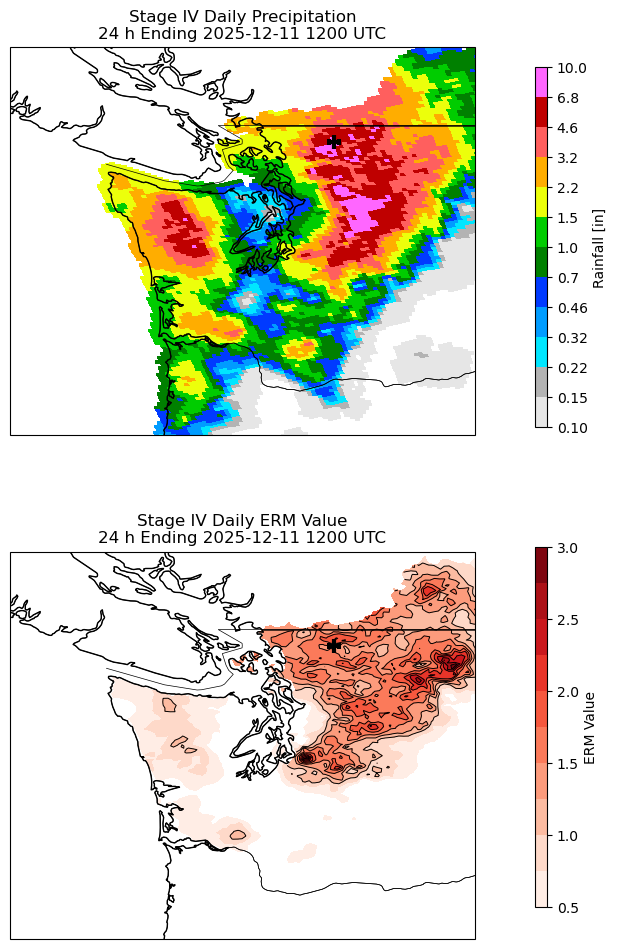

In [385]:
# Read in ERM reference data. Also has the lat/lon grid.
with xr.open_dataset(f"{outdir}/max_daily_precip.MEDIAN.s4.2006_2020.nc") as ds2:
    erm_ref = ds2['precip'].values
    lon = ds2['lon'].values
    lat = ds2['lat'].values

# Read in Stage IV data.
with xr.open_dataset(f"{outdir}/nws_precip_1day_{analysis_date.strftime('%Y%m%d')}_conus.nc") as ds1:
    precip = ds1['observation'].values[::-1,:] # Flip latitudes

fig = plt.figure(figsize=(6, 12))
ax1 = plt.subplot(2,1,1,projection=ccrs.PlateCarree())
ax2 = plt.subplot(2,1,2,projection=ccrs.PlateCarree())

for ax in [ax1, ax2]:
    ax.coastlines()
    ax.add_feature(ccrs.cartopy.feature.BORDERS, linewidth=0.5)
    ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)
    ax.set_extent(plot_area, crs=ccrs.PlateCarree())

# Precip plot
z = precip * 25.4  # Convert from inches to mm
vmin = 0.1 # inches
vmax = 10.0 # inches
h_precip = add_rainfall(ax1, lon, lat, z, min_value=vmin, vmin=vmin, vmax=vmax)
mt_baker = ax1.scatter(mt_baker_lat_lon[1], mt_baker_lat_lon[0], transform=ccrs.PlateCarree(), marker='+', s=100, c='k', linewidth=3)

## Color bar.
cax1 = fig.add_axes([1.00, 0.55, 0.02, 0.3])
hcb1=plt.colorbar(h_precip, label='Rainfall [in]', cax=cax1)

vmin_log = 10*np.log10(vmin)    
vmax_log = 10*np.log10(vmax)
xticks=np.arange(vmin_log,vmax_log+(vmax_log-vmin_log)/12.0,(vmax_log-vmin_log)/12.0)
xticklabels = ['{0:.1f}'.format(np.power(10,x/10)) if np.power(10,x/10) > 0.5 else '{0:.2f}'.format(np.power(10,x/10)) for x in xticks]

hcb1.set_ticks(xticks)
hcb1.set_ticklabels(xticklabels)

ax1.set_title(f"Stage IV Daily Precipitation\n24 h Ending {analysis_date.strftime('%Y-%m-%d 1200 UTC')}")

# ERM plot
erm = precip * 25.4 / erm_ref
herm = ax2.contourf(lon, lat, erm, levels=clevels_erm, cmap='Reds', rasterized=True, transform=ccrs.PlateCarree())
ax2.contour(lon, lat, erm, levels=clevels_erm_gt1, colors='k', linewidths=0.7, transform=ccrs.PlateCarree())

mt_baker = ax2.scatter(mt_baker_lat_lon[1], mt_baker_lat_lon[0], transform=ccrs.PlateCarree(), marker='+', s=100, c='k', linewidth=3)

## Color bar.

cax2 = fig.add_axes([1.00, 0.15, 0.02, 0.3])
hcb2=plt.colorbar(herm, label='ERM Value', cax=cax2)

ax2.set_title(f"Stage IV Daily ERM Value\n24 h Ending {analysis_date.strftime('%Y-%m-%d 1200 UTC')}")

# Save plot
fn_out = f"{plotdir}/StageIV_precip_and_ERM.{analysis_date.strftime('%Y%m%d')}.daily.png"
plt.savefig(fn_out, bbox_inches='tight', dpi=100)
print(f"Saved plot to {fn_out}")

#### 2-Day Precip and ERM

[[0.9        0.9        0.9        1.        ]
 [0.7        0.7        0.7        1.        ]
 [0.         0.9        1.         1.        ]
 [0.         0.61176471 1.         1.        ]
 [0.         0.22745098 1.         1.        ]
 [0.         0.5        0.         1.        ]
 [0.         0.8        0.         1.        ]
 [0.92375367 1.         0.04398827 1.        ]
 [1.         0.67676768 0.         1.        ]
 [1.         0.3721581  0.36983471 1.        ]
 [0.75       0.         0.         1.        ]
 [1.         0.4        1.         1.        ]]


/tmp/ipykernel_1604355/2274082821.py:5: RuntimeWarning: divide by zero encountered in log10
  Z = 10.0*np.log10(Z0/25.4)  ## mm --> inches, then dBR
/tmp/ipykernel_1604355/2274082821.py:5: RuntimeWarning: invalid value encountered in log10
  Z = 10.0*np.log10(Z0/25.4)  ## mm --> inches, then dBR
/tmp/ipykernel_1604355/3404534803.py:45: RuntimeWarning: divide by zero encountered in divide
  erm2 = precip * 25.4 / erm_ref2
/tmp/ipykernel_1604355/3404534803.py:45: RuntimeWarning: invalid value encountered in divide
  erm2 = precip * 25.4 / erm_ref2
/home/disk/orca/bkerns/miniconda3/envs/gaia-hazlab/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1631: UserWarning: The following kwargs were not used by contour: 'rasterized'
  result = super().contourf(*args, **kwargs)


Saved plot to ../plots/stageIV//StageIV_precip_and_ERM.20251211.2day.png


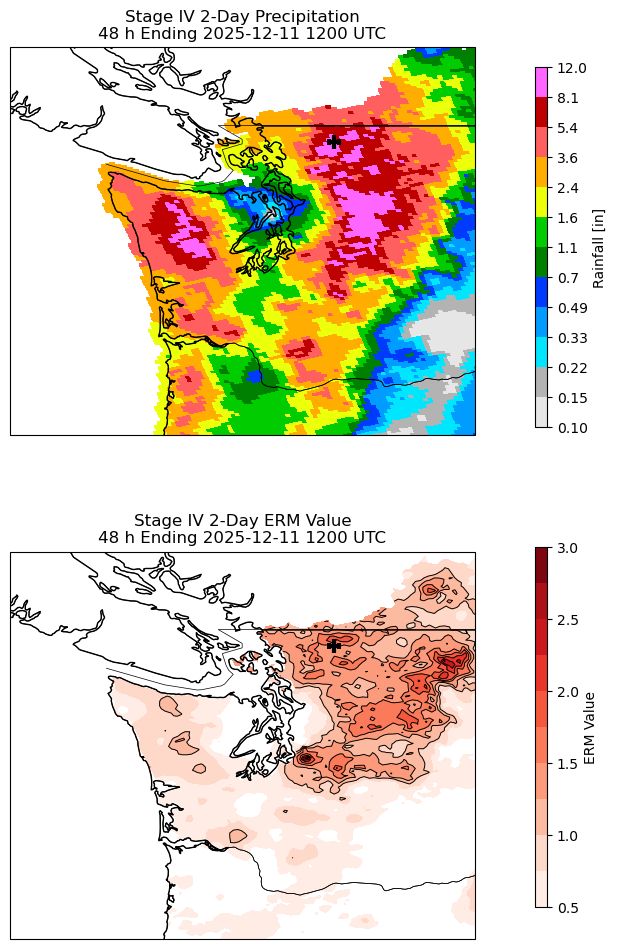

In [386]:
# Read in ERM reference data. Also has the lat/lon grid.
with xr.open_dataset(f"{outdir}/max_2day_precip.MEDIAN.s4.2006_2020.nc") as ds2:
    erm_ref2 = ds2['precip'].values
    lon = ds2['lon'].values
    lat = ds2['lat'].values

# Read in Stage IV data.
with xr.open_dataset(f"{outdir}/nws_precip_1day_{analysis_date.strftime('%Y%m%d')}_conus.nc") as ds1:
    precip = ds1['observation'].values[::-1,:] # Flip latitudes
with xr.open_dataset(f"{outdir}/nws_precip_1day_{analysis_date2.strftime('%Y%m%d')}_conus.nc") as ds1:
    precip += ds1['observation'].values[::-1,:] # Flip latitudes

fig = plt.figure(figsize=(6, 12))
ax1 = plt.subplot(2,1,1,projection=ccrs.PlateCarree())
ax2 = plt.subplot(2,1,2,projection=ccrs.PlateCarree())

for ax in [ax1, ax2]:
    ax.coastlines()
    ax.add_feature(ccrs.cartopy.feature.BORDERS, linewidth=0.5)
    ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)
    ax.set_extent(plot_area, crs=ccrs.PlateCarree())

# Precip plot
z = precip * 25.4  # Convert from inches to mm
vmin = 0.1 # inches
vmax = 12.0 # inches
h_precip = add_rainfall(ax1, lon, lat, z, min_value=vmin, vmin=vmin, vmax=vmax)
mt_baker = ax1.scatter(mt_baker_lat_lon[1], mt_baker_lat_lon[0], transform=ccrs.PlateCarree(), marker='+', s=100, c='k', linewidth=3)

## Color bar.
cax1 = fig.add_axes([1.00, 0.55, 0.02, 0.3])
hcb1=plt.colorbar(h_precip, label='Rainfall [in]', cax=cax1)

vmin_log = 10*np.log10(vmin)    
vmax_log = 10*np.log10(vmax)
xticks=np.arange(vmin_log,vmax_log+(vmax_log-vmin_log)/12.0,(vmax_log-vmin_log)/12.0)
xticklabels = ['{0:.1f}'.format(np.power(10,x/10)) if np.power(10,x/10) > 0.5 else '{0:.2f}'.format(np.power(10,x/10)) for x in xticks]

hcb1.set_ticks(xticks)
hcb1.set_ticklabels(xticklabels)

ax1.set_title(f"Stage IV 2-Day Precipitation\n48 h Ending {analysis_date.strftime('%Y-%m-%d 1200 UTC')}")

# ERM plot
erm2 = precip * 25.4 / erm_ref2
herm = ax2.contourf(lon, lat, erm2, levels=clevels_erm, cmap='Reds', rasterized=True, transform=ccrs.PlateCarree())
ax2.contour(lon, lat, erm2, levels=clevels_erm_gt1, colors='k', linewidths=0.7, transform=ccrs.PlateCarree())

mt_baker = ax2.scatter(mt_baker_lat_lon[1], mt_baker_lat_lon[0], transform=ccrs.PlateCarree(), marker='+', s=100, c='k', linewidth=3)

## Color bar.

cax2 = fig.add_axes([1.00, 0.15, 0.02, 0.3])
hcb2=plt.colorbar(herm, label='ERM Value', cax=cax2)

ax2.set_title(f"Stage IV 2-Day ERM Value\n48 h Ending {analysis_date.strftime('%Y-%m-%d 1200 UTC')}")

# Save plot
fn_out = f"{plotdir}/StageIV_precip_and_ERM.{analysis_date.strftime('%Y%m%d')}.2day.png"
plt.savefig(fn_out, bbox_inches='tight', dpi=100)
print(f"Saved plot to {fn_out}")


#### 3-Day Precip and ERM

[[0.9        0.9        0.9        1.        ]
 [0.7        0.7        0.7        1.        ]
 [0.         0.9        1.         1.        ]
 [0.         0.61176471 1.         1.        ]
 [0.         0.22745098 1.         1.        ]
 [0.         0.5        0.         1.        ]
 [0.         0.8        0.         1.        ]
 [0.92375367 1.         0.04398827 1.        ]
 [1.         0.67676768 0.         1.        ]
 [1.         0.3721581  0.36983471 1.        ]
 [0.75       0.         0.         1.        ]
 [1.         0.4        1.         1.        ]]


/tmp/ipykernel_1604355/2274082821.py:5: RuntimeWarning: divide by zero encountered in log10
  Z = 10.0*np.log10(Z0/25.4)  ## mm --> inches, then dBR
/tmp/ipykernel_1604355/2274082821.py:5: RuntimeWarning: invalid value encountered in log10
  Z = 10.0*np.log10(Z0/25.4)  ## mm --> inches, then dBR
/tmp/ipykernel_1604355/3004406556.py:47: RuntimeWarning: divide by zero encountered in divide
  erm3 = precip * 25.4 / erm_ref3
/tmp/ipykernel_1604355/3004406556.py:47: RuntimeWarning: invalid value encountered in divide
  erm3 = precip * 25.4 / erm_ref3
/home/disk/orca/bkerns/miniconda3/envs/gaia-hazlab/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1631: UserWarning: The following kwargs were not used by contour: 'rasterized'
  result = super().contourf(*args, **kwargs)


Saved plot to ../plots/stageIV//StageIV_precip_and_ERM.20251211.3day.png


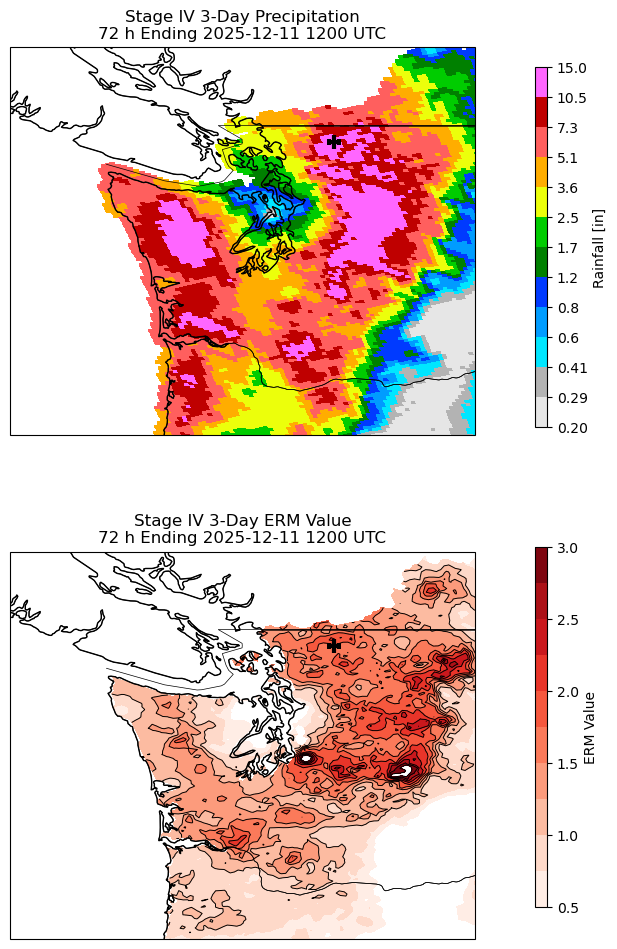

In [387]:
# Read in ERM reference data. Also has the lat/lon grid.
with xr.open_dataset(f"{outdir}/max_3day_precip.MEDIAN.s4.2006_2020.nc") as ds2:
    erm_ref3 = ds2['precip'].values
    lon = ds2['lon'].values
    lat = ds2['lat'].values

# Read in Stage IV data.
with xr.open_dataset(f"{outdir}/nws_precip_1day_{analysis_date.strftime('%Y%m%d')}_conus.nc") as ds1:
    precip = ds1['observation'].values[::-1,:] # Flip latitudes
with xr.open_dataset(f"{outdir}/nws_precip_1day_{analysis_date2.strftime('%Y%m%d')}_conus.nc") as ds1:
    precip += ds1['observation'].values[::-1,:] # Flip latitudes
with xr.open_dataset(f"{outdir}/nws_precip_1day_{analysis_date3.strftime('%Y%m%d')}_conus.nc") as ds1:
    precip += ds1['observation'].values[::-1,:] # Flip latitudes

fig = plt.figure(figsize=(6, 12))
ax1 = plt.subplot(2,1,1,projection=ccrs.PlateCarree())
ax2 = plt.subplot(2,1,2,projection=ccrs.PlateCarree())

for ax in [ax1, ax2]:
    ax.coastlines()
    ax.add_feature(ccrs.cartopy.feature.BORDERS, linewidth=0.5)
    ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)
    ax.set_extent(plot_area, crs=ccrs.PlateCarree())

# Precip plot
z = precip * 25.4  # Convert from inches to mm
vmin = 0.2 # inches
vmax = 15.0 # inches
h_precip = add_rainfall(ax1, lon, lat, z, min_value=vmin, vmin=vmin, vmax=vmax)
mt_baker = ax1.scatter(mt_baker_lat_lon[1], mt_baker_lat_lon[0], transform=ccrs.PlateCarree(), marker='+', s=100, c='k', linewidth=3)

## Color bar.
cax1 = fig.add_axes([1.00, 0.55, 0.02, 0.3])
hcb1=plt.colorbar(h_precip, label='Rainfall [in]', cax=cax1)

vmin_log = 10*np.log10(vmin)    
vmax_log = 10*np.log10(vmax)
xticks=np.arange(vmin_log,vmax_log+(vmax_log-vmin_log)/12.0,(vmax_log-vmin_log)/12.0)
xticklabels = ['{0:.1f}'.format(np.power(10,x/10)) if np.power(10,x/10) > 0.5 else '{0:.2f}'.format(np.power(10,x/10)) for x in xticks]

hcb1.set_ticks(xticks)
hcb1.set_ticklabels(xticklabels)

ax1.set_title(f"Stage IV 3-Day Precipitation\n72 h Ending {analysis_date.strftime('%Y-%m-%d 1200 UTC')}")

# ERM plot
erm3 = precip * 25.4 / erm_ref3
herm = ax2.contourf(lon, lat, erm3, levels=clevels_erm, cmap='Reds', rasterized=True, transform=ccrs.PlateCarree())
ax2.contour(lon, lat, erm3, levels=clevels_erm_gt1, colors='k', linewidths=0.7, transform=ccrs.PlateCarree())

mt_baker = ax2.scatter(mt_baker_lat_lon[1], mt_baker_lat_lon[0], transform=ccrs.PlateCarree(), marker='+', s=100, c='k', linewidth=3)

## Color bar.

cax2 = fig.add_axes([1.00, 0.15, 0.02, 0.3])
hcb2=plt.colorbar(herm, label='ERM Value', cax=cax2)

ax2.set_title(f"Stage IV 3-Day ERM Value\n72 h Ending {analysis_date.strftime('%Y-%m-%d 1200 UTC')}")

# Save plot
fn_out = f"{plotdir}/StageIV_precip_and_ERM.{analysis_date.strftime('%Y%m%d')}.3day.png"
plt.savefig(fn_out, bbox_inches='tight', dpi=100)
print(f"Saved plot to {fn_out}")


#### Composite ERM value

To account for the various scales at which flooding can occur,
the max of 1, 2, and 3-day ERM best represents overall flood potential

Saved plot to ../plots/stageIV//StageIV_composite_ERM.20251211.png


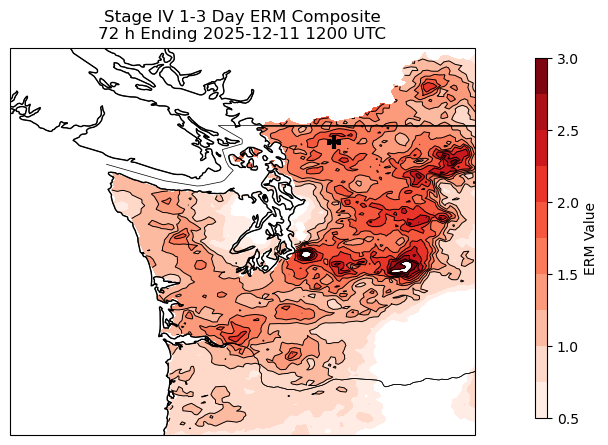

In [388]:
erm_composite = np.maximum.reduce([erm, erm2, erm3])

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
for ax in [ax]:
    ax.coastlines()
    ax.add_feature(ccrs.cartopy.feature.BORDERS, linewidth=0.5)
    ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)
    ax.set_extent(plot_area, crs=ccrs.PlateCarree())


herm = ax.contourf(lon, lat, erm_composite, levels=clevels_erm, cmap='Reds', transform=ccrs.PlateCarree())
ax.contour(lon, lat, erm_composite, levels=clevels_erm_gt1, colors='k', linewidths=0.7, transform=ccrs.PlateCarree())

mt_baker = ax.scatter(mt_baker_lat_lon[1], mt_baker_lat_lon[0], transform=ccrs.PlateCarree(), marker='+', s=100, c='k', linewidth=3)

## Color bar.

cax2 = fig.add_axes([1.00, 0.2, 0.02, 0.6])
hcb2=plt.colorbar(herm, label='ERM Value', cax=cax2)

ax.set_title(f"Stage IV 1-3 Day ERM Composite\n72 h Ending {analysis_date.strftime('%Y-%m-%d 1200 UTC')}")

# Save plot
fn_out = f"{plotdir}/StageIV_composite_ERM.{analysis_date.strftime('%Y%m%d')}.png"
plt.savefig(fn_out, bbox_inches='tight', dpi=100)
print(f"Saved plot to {fn_out}")
